# Imports and intializations

* When the variable 'GeNN_backend' is set to True, the GeNN backend will be used (Brian2GeNN). It will download and set up everything needed to use it.

* GeNN speeds up the simulations significantly. However, it adds a long compilation time to the simulation. As all the cells in this notebook are just short examples, using the GeNN back end in every cell is not worth it here. 

* If you want to try Brian2GeNN, you can execute one of the cells with the GeNN backend. Just make sure you select the GPU runtime in google colab (Runtime>Change runtime tipe>GPU). However, it is recommended to switch back to the CPU runtime (Runtime>Change runtime tipe>None) and use just Brian2 to execute the below cells faster.

In [1]:
############## IMPORTS AND INITIALIZATIONS ##############

# Istall brian
!pip install brian2==2.4.2


# Imports
from brian2 import *
import matplotlib.pyplot as plt
import numpy as np



##--- GeNN backend ---##

# If False only Brian is used. If True Brian2GeNN is used.
GeNN_backend = False  

if GeNN_backend:

  # Download GeNN
  !git clone https://github.com/genn-team/genn.git

  # Paths
  import os
  os.environ['PATH'] += ":/content/genn/bin"
  os.environ['CUDA_PATH'] = "/usr/local/cuda"

  # Install Brian2GeNN
  !pip install brian2genn==1.6

  # Activate backend
  import brian2genn
  set_device('genn')




     |████████████████████████████████| 1.2 MB 13.8 MB/s 
  Created wheel for brian2: filename=Brian2-2.4.2-cp37-cp37m-linux_x86_64.whl size=1257169 sha256=cb07448412f861e854e8cf7506d95bf7e00e633fa308497e3efed705644deaa9
  Stored in directory: /root/.cache/pip/wheels/ec/f8/22/34f71a38e2efba1a88d548d18cd2a8fe35692879503e97b5f7
Successfully built brian2


In [2]:
############## FUNCTIONS ##############

def visualise_connectivity(S, title=''):
    Ns = len(S.source)
    Nt = len(S.target)
    figure(figsize=(5, 4))
    plot(zeros(Ns), arange(Ns), 'ok', ms=10)
    plot(ones(Nt), arange(Nt), 'ok', ms=10)
    for i, j in zip(S.i, S.j):
        plot([0, 1], [i, j], '-k')
    xticks([0, 1], ['G_in', 'G_out'])
    ylabel('Neuron index')
    xlim(-0.1, 1.1)
    ylim(-1, max(Ns, Nt))
    plt.title(title)
    plt.show()


    
def rate_per_neuron(spikemon, neurons, duration):
    # Count spikes per neuron
    value, counts = np.unique(spikemon.i, return_counts=True)
    # Convert to Herz
    scale_factor = 1000/duration
    counts = counts * scale_factor
    # Set 0Hz to silent neurons
    r = np.array([0]*neurons)
    for v, c in zip(value, counts):
        r[v] = c 
    return r


# BASICS - Neurons and monitors

Here we construct a group of neurons (LIF). We split them in two subgroups and inject them different input currents. We then visualize the membrane potential and spikes of each neuron. Also we visualize the average firing rate of the entire population.


INFO       width adjusted from 5. ms to 5.1 ms [brian2.monitors.ratemonitor.adjusted_width]


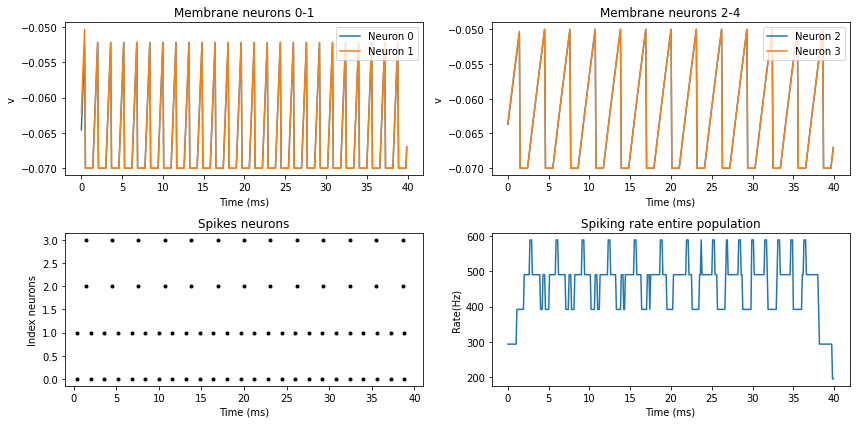

In [4]:
############## NEURONS AND MONITORS ##############

# Restart Brian objects
start_scope()


# Restart GeNN backend
if GeNN_backend:
  device.reinit()
  device.activate()


# Parameters
vr = -70*mV
vth = -50*mV
tau = 20*ms
n_neurons = 4
refractory = 1*ms


# Neurons population
eqs='''
dv/dt = (vr - v + I)/tau : volt (unless refractory)
I : volt
'''
reset='''
v=vr
'''
G = NeuronGroup(n_neurons, eqs, threshold='v>vth', reset=reset, 
                refractory=refractory, method='euler')


# Subgroups
G1 = G[:int(n_neurons/2)]
G2 = G[int(n_neurons/2):]


# Initializations
G.v = 'vth + rand()*(vr-vth)' # All neurons
G1.I = '0.6*volt'             # First group
G2.I = '0.2*volt'             # Second group


# Monitors
monitor_v = StateMonitor(G, 'v', record=True)
monitor_spk = SpikeMonitor(G)
monitor_rate = PopulationRateMonitor(G)


# Run simulation
simulation_time=40
run(simulation_time*ms)


# Visualizations
plt.figure(figsize=(12,6))
plt.subplot(221)
for n in range(int(len(monitor_v.v)/2)):
    plot(monitor_v.t/ms, monitor_v.v[n], label='Neuron '+str(n))
xlabel('Time (ms)')
ylabel('v')
plt.title('Membrane neurons 0-'+str(int(len(monitor_v.v)/2)-1))
plt.legend(loc='upper right')

plt.subplot(222)
for n in range(int(len(monitor_v.v)/2)):
    plot(monitor_v.t/ms, monitor_v.v[int(len(monitor_v.v)/2)+n], label='Neuron '+str(int(len(monitor_v.v)/2)+n))
xlabel('Time (ms)')
ylabel('v')
plt.title('Membrane neurons '+str(int(len(monitor_v.v)/2))+'-'+str(len(monitor_v.v)))
plt.legend(loc='upper right')

plt.subplot(223)
plot(monitor_spk.t/ms, monitor_spk.i, '.k')
xlabel('Time (ms)')
ylabel('Index neurons')
plt.title('Spikes neurons')
plt.xlim(left=-1, right=simulation_time+1)

plt.subplot(224)
plot(monitor_rate.t/ms, monitor_rate.smooth_rate(window='flat', width=5*ms))
xlabel('Time (ms)')
ylabel('Rate(Hz)')
plt.title("Spiking rate entire population")
plt.tight_layout()
plt.show()


# BASICS - Synapses conectivity

Here we create
visualize different connectivity among neurons


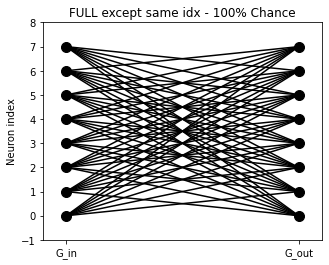

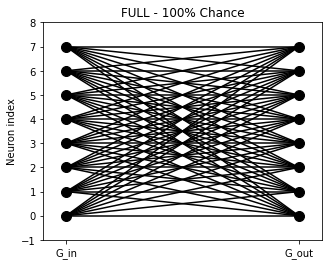

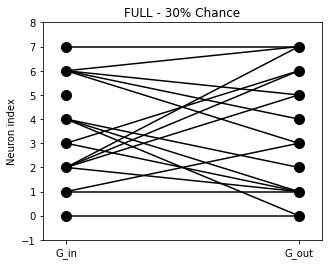

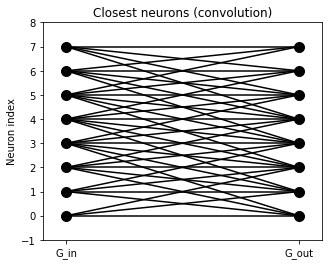

In [ ]:
############## SYNAPSES - CONNECTIVITY ##############

# Restart Brian objects
start_scope()


# Restart GeNN backend
if GeNN_backend:
  device.reinit()
  device.activate()


# Parameters
vr = -70*mV
vth = -50*mV
tau = 20*ms
n_neurons = 16
refractory = 1*ms


# Neurons population
eqs='''
dv/dt = (vr - v + I)/tau : volt (unless refractory)
I : volt
'''
reset='''
v=vr
'''
G = NeuronGroup(n_neurons, eqs, threshold='v>vth', reset=reset, refractory=refractory, method='euler')


# Subgroups
G_in = G[:int(n_neurons/2)]
G_out = G[int(n_neurons/2):]


# Connectivity (FULL except same idx - 100% Chance)
S = Synapses(G_in, G_out)
S.connect(condition='j!=i', p=1.0)
visualise_connectivity(S, 'FULL except same idx - 100% Chance')


# Connectivity (FULL - 100% Chance)
S = Synapses(G_in, G_out)
S.connect(p=1.0)
visualise_connectivity(S, 'FULL - 100% Chance')


# Connectivity (FULL - 30% chance)
S = Synapses(G_in, G_out)
S.connect(p=0.3)
visualise_connectivity(S, 'FULL - 30% Chance')


# Connectivity (Closest neurons - convolution)
S = Synapses(G_in, G_out)
S.connect(j='k for k in range(i-3, i+3)', skip_if_invalid=True)
visualise_connectivity(S,'Closest neurons (convolution)') 




# BASICS - Synapses post spike effect (current injection)

Here we use a group of Leaky Integrate and Fire (LIF) neuron model. They are split into neurons in the input (that receive an input current) and neurons in the output (that don't receive an input current).

Input and output neurons are fully connected, and the post spike effect is just an injection of current on the post-synaptic neuron's membrane.


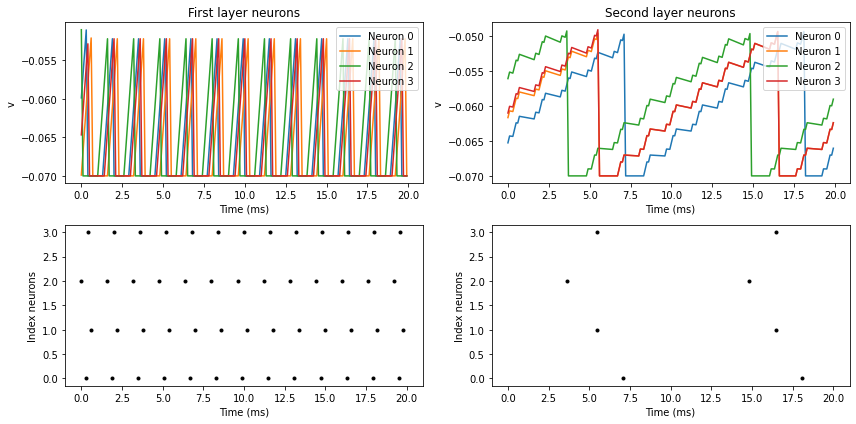

In [5]:
############## SYNAPSES - POST SPIKE EFFECT ##############

# Restart Brian objects
start_scope()


# Restart GeNN backend
if GeNN_backend:
  device.reinit()
  device.activate()
  

# Parameters
vr = -70*mV
vth = -50*mV
tau = 20*ms
n_neurons = 8
refractory = 1*ms


# Neurons population
eqs='''
dv/dt = (vr - v + I)/tau : volt (unless refractory)
I : volt
'''
reset='''
v=vr
'''
G = NeuronGroup(n_neurons, eqs, threshold='v>vth', reset=reset, refractory=refractory, method='euler')

# Subgroups
G_in = G[:int(n_neurons/2)]
G_out = G[int(n_neurons/2):]


# Initializations
G.v = 'vth + rand()*(vr-vth)' # All neurons
G_in.I = '0.6*volt'             # First group
G_out.I = '0*volt'             # Second group


# Connectivity and synapses
S = Synapses(G_in, G_out, on_pre='v_post += 1*mV')
S.connect(p=1.0)


# Monitors
monitor_v = StateMonitor(G, 'v', record=True)
monitor_spk_in = SpikeMonitor(G_in)
monitor_spk_out = SpikeMonitor(G_out)


# Run simulation
simulation_time = 20
run(simulation_time*ms)


# Visualizations
plt.figure(figsize=(12,6))
plt.subplot(221)
for n in range(int(len(monitor_v.v)/2)):
    plot(monitor_v.t/ms, monitor_v.v[n], label='Neuron '+str(n))
xlabel('Time (ms)')
ylabel('v')
plt.legend(loc='upper right')
plt.title('First layer neurons')

plt.subplot(222)
for n in range(int(len(monitor_v.v)/2)):
    plot(monitor_v.t/ms, monitor_v.v[int(len(monitor_v.v)/2)+n], label='Neuron '+str(n))
xlabel('Time (ms)')
ylabel('v')
plt.legend(loc='upper right')
plt.title('Second layer neurons')

plt.subplot(223)
plot(monitor_spk_in.t/ms, monitor_spk_in.i, '.k')
xlabel('Time (ms)')
ylabel('Index neurons')
plt.xlim(left=-1, right=simulation_time+1)

plt.subplot(224)
plot(monitor_spk_out.t/ms, monitor_spk_out.i, '.k')
xlabel('Time (ms)')
ylabel('Index neurons')
plt.xlim(left=-1, right=simulation_time+1)
plt.tight_layout()
plt.show()


# BASICS - Synapses post spike effect (conductance)

Here we use a Leaky Integrate and Fire (LIF) neuron model for the neurons in the first layer and a conductance-based model for the neurons in the second layer.

Input and output neurons are fully connected, and the post spike effect will make the neurons's excitatory inputs more dominant.


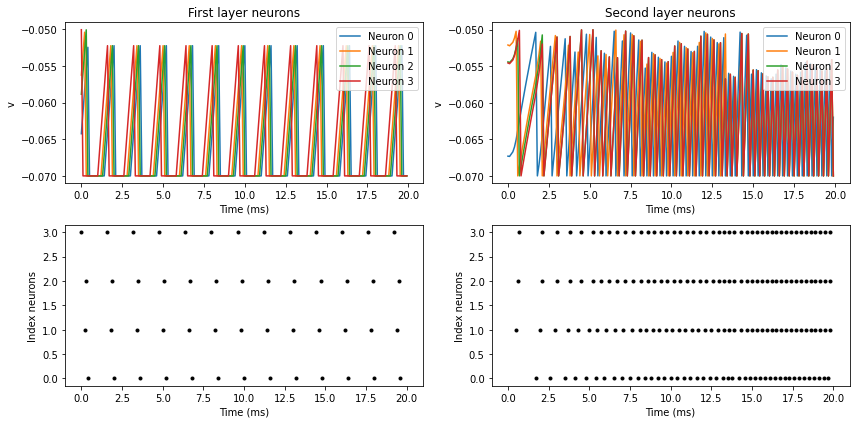

In [6]:
############## SYNAPSES - POST SPIKE EFFECT ##############

# Restart Brian objects
start_scope()


# Restart GeNN backend
if GeNN_backend:
  device.reinit()
  device.activate()
  

## --- FIRST LAYER -- ##

# Parameters
vr = -70*mV
vth = -50*mV
tau = 20*ms
n_neurons = 8
refractory = 1*ms


# Neurons population
eqs='''
dv/dt = (vr - v + I)/tau : volt (unless refractory)
I : volt
'''
reset='''
v=vr
'''
G_in = NeuronGroup(int(n_neurons/2), eqs, threshold='v>vth', reset=reset, refractory=refractory, method='euler')


## --- SECOND LAYER -- ##

# New parameters
Ee = 0*mV    # Excitatory input
El = -74*mV  # Inhibitory input
taue = 10*ms

# Neurons population
eqs='''
dv/dt = (ge * (Ee-vr) + El - v)/tau : volt
dge/dt = -ge/taue : 1
'''
G_out = NeuronGroup(int(n_neurons/2), eqs, threshold='v>vth', reset=reset, method='euler')


# Initializations
G_in.v = 'vth + rand()*(vr-vth)' 
G_out.v = 'vth + rand()*(vr-vth)' 
G_in.I = '0.6*volt'             


# Connectivity and synapses
S = Synapses(G_in, G_out, on_pre='ge_post += 1')
S.connect(p=1.0)


# Monitors
monitor_v_in = StateMonitor(G_in, 'v', record=True)
monitor_v_out = StateMonitor(G_out, 'v', record=True)
monitor_spk_in = SpikeMonitor(G_in)
monitor_spk_out = SpikeMonitor(G_out)


# Run simulation
simulation_time = 20
run(simulation_time*ms)


# Visualizations
plt.figure(figsize=(12,6))
plt.subplot(221)
for n in range(len(monitor_v_in.v)):
  plot(monitor_v_in.t/ms, monitor_v_in.v[n], label='Neuron '+str(n))
xlabel('Time (ms)')
ylabel('v')
plt.legend(loc='upper right')
plt.title('First layer neurons')

plt.subplot(222)
for n in range(len(monitor_v_out.v)):
    plot(monitor_v_out.t/ms, monitor_v_out.v[n], label='Neuron '+str(n))
xlabel('Time (ms)')
ylabel('v')
plt.legend(loc='upper right')
plt.title('Second layer neurons')

plt.subplot(223)
plot(monitor_spk_in.t/ms, monitor_spk_in.i, '.k')
xlabel('Time (ms)')
ylabel('Index neurons')
plt.xlim(left=-1, right=simulation_time+1)

plt.subplot(224)
plot(monitor_spk_out.t/ms, monitor_spk_out.i, '.k')
xlabel('Time (ms)')
ylabel('Index neurons')
plt.xlim(left=-1, right=simulation_time+1)
plt.tight_layout()
plt.show()


# SIMULATIONS - Neurons input (spikes)

Here we use a two groups of neurons as input: poisson spikes generator and a uniform spikes generator. In the second layer we have a group of LIF neurons, which recieve an injection of current from the neurons in the input.


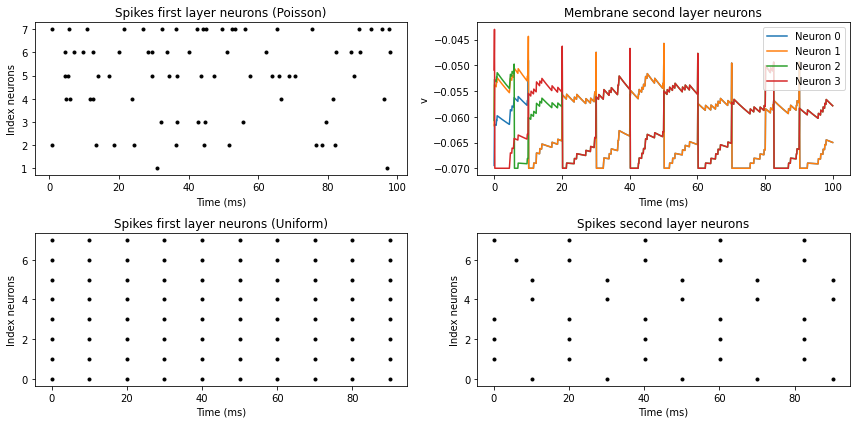

In [ ]:
############## NEURONS INPUTS - SPIKES ##############

# Restart Brian objects
start_scope()


# Restart GeNN backend
if GeNN_backend:
  device.reinit()
  device.activate()
  

# Parameters
vr = -70*mV
vth = -50*mV
tau = 20*ms
n_neurons = 8
refractory = 1*ms


# Spiking rate different for each input neuron in Poisson group (bewteen 10 and 220 Hz)
spk_rates_input = np.arange(n_neurons)*30*Hz + 10*Hz  

# Fixed spiking rate for every neuron in the uniform spike generator
spk_period_input = (n_neurons+2)*ms


## --- FIRST LAYER -- ##

# Input poisson spikes
G_in1 = PoissonGroup(n_neurons, spk_rates_input)

# Input uniform spikes
G_in2 = SpikeGeneratorGroup(N=n_neurons, indices=range(n_neurons), times=[0]*n_neurons*ms, period=spk_period_input)


## --- SCEOND LAYER -- ##

# Neurons population
eqs='''
dv/dt = (vr - v + I)/tau : volt (unless refractory)
I : volt
'''
reset='''
v=vr
'''
G_out = NeuronGroup(n_neurons, eqs, threshold='v>vth', reset=reset, refractory=refractory, method='euler')


# Initializations
G_out.v = 'vth + rand()*(vr-vth)'
G_out.I = '0*volt'                


# Connectivity and synapses
S1 = Synapses(G_in1, G_out, on_pre='v_post += 1*mV')
S1.connect(p=1.0)
S2 = Synapses(G_in2, G_out, on_pre='v_post += 1*mV')
S2.connect(p=1.0)


# Monitors
monitor_v = StateMonitor(G_out, 'v', record=True)
monitor_spk_in1 = SpikeMonitor(G_in1)
monitor_spk_in2 = SpikeMonitor(G_in2)
monitor_spk_out = SpikeMonitor(G_out)


# Run simulation
simulation_time = 100
run(simulation_time*ms)


# Visualizations
plt.figure(figsize=(12,6))
plt.subplot(221)
plot(monitor_spk_in1.t/ms, monitor_spk_in1.i, '.k')
xlabel('Time (ms)')
ylabel('Index neurons')
plt.title('Spikes first layer neurons (Poisson)')
plt.xlim(left=-1, right=simulation_time+1)

plt.subplot(222)
for n in range(int(len(monitor_v.v)/2)):
    plot(monitor_v.t/ms, monitor_v.v[int(len(monitor_v.v)/2)+n], label='Neuron '+str(n))
xlabel('Time (ms)')
ylabel('v')
plt.legend(loc='upper right')
plt.title('Membrane second layer neurons')

plt.subplot(223)
plot(monitor_spk_in2.t/ms, monitor_spk_in2.i, '.k')
xlabel('Time (ms)')
ylabel('Index neurons')
plt.title('Spikes first layer neurons (Uniform)')
plt.xlim(left=-1, right=simulation_time+1)

plt.subplot(224)
plot(monitor_spk_out.t/ms, monitor_spk_out.i, '.k')
xlabel('Time (ms)')
ylabel('Index neurons')
plt.title('Spikes second layer neurons')
plt.xlim(left=-1, right=simulation_time+1)
plt.tight_layout()
plt.show()


# SIMULATIONS - Neurons input (non-static)

Here we use a group of Leaky Integrate and Fire (LIF) neuron model. They are split into neurons in the input (that receive an input current) and neurons in the output (that don't receive an input current).

Input and output neurons are fully connected, and the post spike effect is just an injection of current on the post-synaptic neuron's membrane.

The input current injected in the input neuron is random and changes every 10ms during the simulation


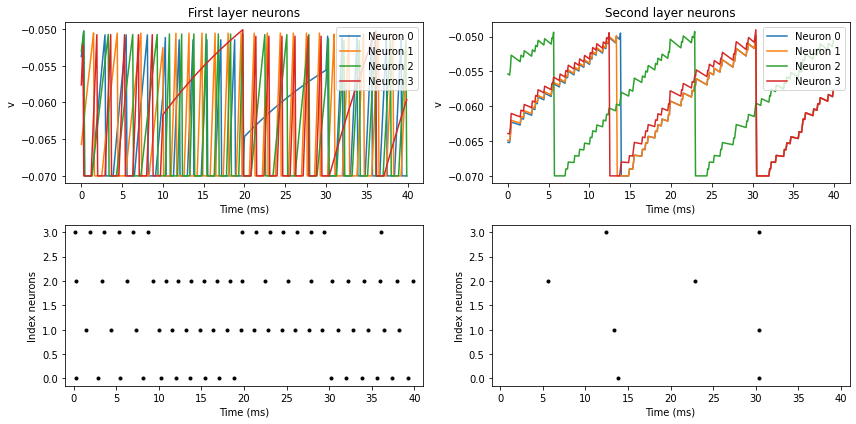

In [11]:
############## NEURONS INPUTS - NON-STATIC ##############

# Restart Brian objects
start_scope()


# Restart GeNN backend
if GeNN_backend:
  device.reinit()
  device.activate()
  

# Parameters
vr = -70*mV
vth = -50*mV
tau = 20*ms
n_neurons = 8
refractory = 1*ms


# Neurons population
eqs='''
dv/dt = (vr - v + I)/tau : volt (unless refractory)
I : volt
'''
reset='''
v=vr
'''
G = NeuronGroup(n_neurons, eqs, threshold='v>vth', reset=reset, refractory=refractory, method='euler')

# Subgroups
G_in = G[:int(n_neurons/2)]
G_out = G[int(n_neurons/2):]


# Initializations
G.v = 'vth + rand()*(vr-vth)' # All neurons
G_out.I = '0*volt'             # Second group


# Create random input changing every 10 seconds
inputs = np.random.random((4, n_neurons))*volt
ta_inputs = TimedArray(inputs, dt=10*ms)


# Parallel run modifying input
G_in.run_regularly('I = ta_inputs(t, i)', dt=10*ms)


# Connectivity and synapses
S = Synapses(G_in, G_out, on_pre='v_post += 1*mV')
S.connect(p=1.0)


# Monitors
monitor_v = StateMonitor(G, 'v', record=True)
monitor_spk_in = SpikeMonitor(G_in)
monitor_spk_out = SpikeMonitor(G_out)


# Run simulation
simulation_time = 40
run(simulation_time*ms)


# Visualizations
plt.figure(figsize=(12,6))
plt.subplot(221)
for n in range(int(len(monitor_v.v)/2)):
    plot(monitor_v.t/ms, monitor_v.v[n], label='Neuron '+str(n))
xlabel('Time (ms)')
ylabel('v')
plt.legend(loc='upper right')
plt.title('First layer neurons')

plt.subplot(222)
for n in range(int(len(monitor_v.v)/2)):
    plot(monitor_v.t/ms, monitor_v.v[int(len(monitor_v.v)/2)+n], label='Neuron '+str(n))
xlabel('Time (ms)')
ylabel('v')
plt.legend(loc='upper right')
plt.title('Second layer neurons')

plt.subplot(223)
plot(monitor_spk_in.t/ms, monitor_spk_in.i, '.k')
xlabel('Time (ms)')
ylabel('Index neurons')
plt.xlim(left=-1, right=simulation_time+1)

plt.subplot(224)
plot(monitor_spk_out.t/ms, monitor_spk_out.i, '.k')
xlabel('Time (ms)')
ylabel('Index neurons')
plt.xlim(left=-1, right=simulation_time+1)
plt.tight_layout()
plt.show()


# SIMULATIONS - Neurons inputs (using datasets)

Here we construct a group of neurons (LIF) that receive an MNIST sample as input. We assign one neuron per pixel in the image, and the normalize value of the pixel will be the input current (I) to the neuron.


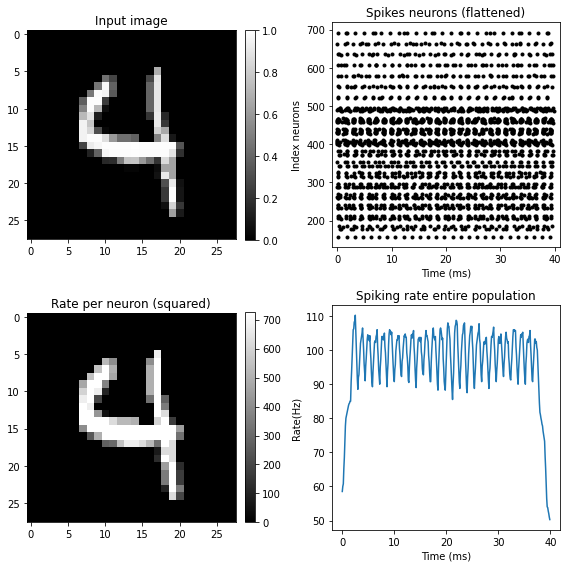

In [43]:
############## MONITORS ##############

# Get MNIST dataset
from keras.datasets import mnist
(train_X, train_Y), (_, _) = mnist.load_data()
train_X = (train_X - 0) / (255 - 0) # Normalize
train_X = train_X.reshape(train_X.shape[0], train_X.shape[1]*train_X.shape[2])  # Flatten samples
sample = train_X[np.random.choice(len(train_X))] # Pick random sample


# Restart Brian objects
start_scope()


# Restart GeNN backend
if GeNN_backend:
  device.reinit()
  device.activate()


# Parameters
vr = -70*mV
vth = -50*mV
tau = 20*ms
n_neurons = len(sample)
refractory = 1*ms


# Neurons population
eqs='''
dv/dt = (vr - v + I)/tau : volt (unless refractory)
I : volt
'''
reset='''
v=vr
'''
G = NeuronGroup(n_neurons, eqs, threshold='v>vth', reset=reset, 
                refractory=refractory, method='euler')


# Initializations
G.v = 'vth + rand()*(vr-vth)' # All neurons
G.I = sample*volt


# Monitors
monitor_spk = SpikeMonitor(G)


# Run simulation
simulation_time=40
run(simulation_time*ms)


# Calculate spiking rate of each neuron
rates = rate_per_neuron(monitor_spk, n_neurons, simulation_time)

# Visualizations
plt.figure(figsize=(8,8))
plt.subplot(221)
plt.title('Input image')
plt.imshow(sample.reshape((28, 28)), cmap='gray')
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(222)
plot(monitor_spk.t/ms, monitor_spk.i, '.k')
xlabel('Time (ms)')
ylabel('Index neurons')
plt.title('Spikes neurons (flattened)')
plt.xlim(left=-1, right=simulation_time+1)

plt.subplot(223)
plt.title('Rate per neuron (squared)')
plt.imshow(rates.reshape((28, 28)), cmap='gray')
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(224)
plot(monitor_rate.t/ms, monitor_rate.smooth_rate(window='flat', width=5*ms))
xlabel('Time (ms)')
ylabel('Rate(Hz)')
plt.title("Spiking rate entire population")
plt.tight_layout()
plt.show()



# SIMULATIONS - Weights updates

Here we implement a simple form of Spike Timing Dependent Plasticity (STDP) between two neurons. The second

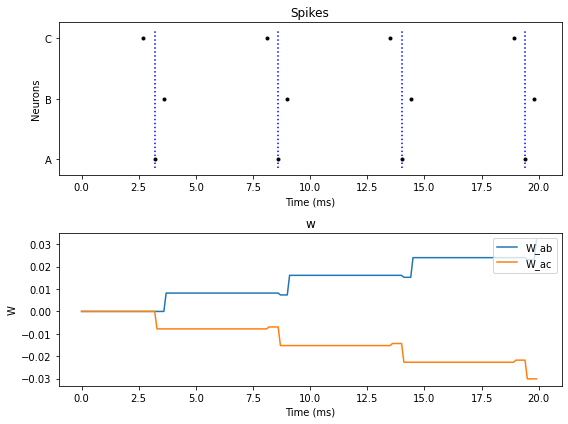

In [8]:
############## WEIGHTS UPDATES - SIMPLE STDP ##############

# Restart Brian objects
start_scope()


# Restart GeNN backend
if GeNN_backend:
  device.reinit()
  device.activate()
  

# Parameters
vr = -70*mV
vth = -50*mV
tau = 20*ms
refractory = 1*ms


# Neurons population
eqs='''
dv/dt = (vr - v + I)/tau : volt (unless refractory)
I : volt
'''
reset='''
v=vr
'''
G = NeuronGroup(3, eqs, threshold='v>vth', reset=reset, refractory=refractory, method='euler')


# Subgroups
G_in = G[0]
G_out = G[1:]


# Initializations
G.v = [-64, -66, -62]*mV
G.I = '0.1*volt'           


# Increase trace
inc = 0.01
tau_trace = tau/10  # Much faster than neuron's membrane

# Connectivity and synapses
#   *Neuron's spikes don't affect other neurons
#   *xpre and xpots are traces used to track the neuron's spiking rate 
#   *xpre is positive and xpost negative
S = Synapses(G_in, G_out,
             '''
             w : 1
             dxpre/dt = -xpre/tau_trace : 1 (event-driven)
             dxpost/dt = -xpost/tau_trace : 1 (event-driven)
             ''',
             on_pre='''
             xpre += inc
             w += xpost
             ''',
             on_post='''
             xpost += -inc
             w += xpre
             ''')
S.connect(p=1.0)


# Monitors
monitor_vars = StateMonitor(S, ['w', 'xpre', 'xpost'], record=True)
monitor_spk = SpikeMonitor(G)


# Run simulation
simulation_time = 20
run(simulation_time*ms)


# Visualizations
plt.figure(figsize=(8,6))
subplot(211)
idx = np.array(monitor_spk.t/ms)[np.where(np.array(monitor_spk.i)==0)]
plot(monitor_spk.t/ms, monitor_spk.i, '.k')
xlabel('Time (ms)')
ylabel('Neurons')
plt.title('Spikes')
plt.xlim(left=-1, right=21)
plt.yticks([0, 1, 2], ['A', 'B', 'C'])
plt.vlines(idx, -0.15, 2.15, linestyles='dotted', color='blue')

subplot(212)
plot(monitor_vars.t/ms, monitor_vars.w[0], label='W_ab')
plot(monitor_vars.t/ms, monitor_vars.w[1], label='W_ac')
xlabel('Time (ms)')
ylabel('W')
plt.legend(loc='upper right')
plt.title('w')
plt.xlim(left=-1, right=simulation_time+1)
plt.tight_layout()
plt.show()


# TASK 1 - LIF with adaptive threshold

Here we use Leaky Integrate and Fire (LIF) neurons. Implement an adaptive threshold that will reduce the spiking rate of the neuron when spiking consecutively.

The threshold is defined as a dynamical system that tends to a base value. Everytime a spike occurs, the threshold is icnreased

INFO       width adjusted from 10. ms to 10.1 ms [brian2.monitors.ratemonitor.adjusted_width]


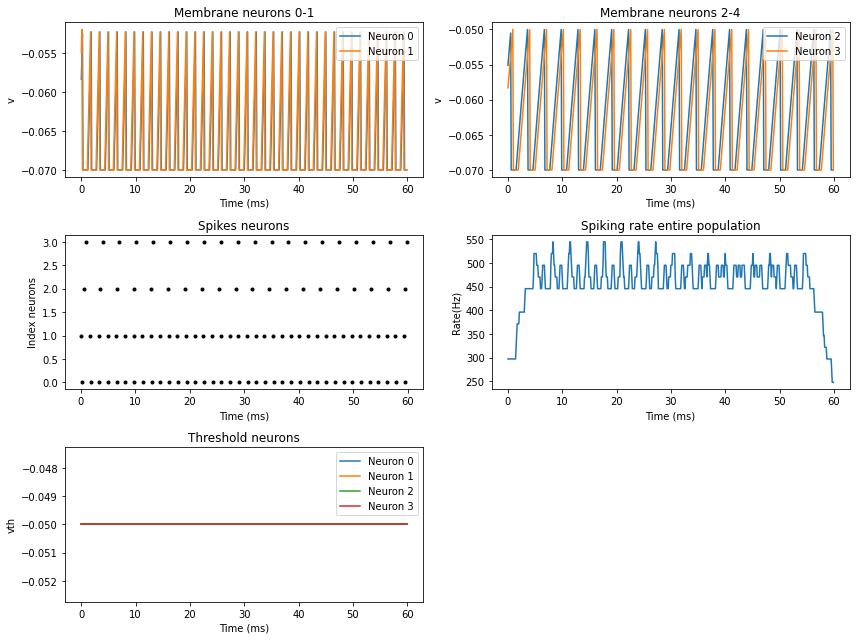

In [3]:
############## ADAPTIVE THRESHOLD ##############

# Restart Brian objects
start_scope()


# Restart GeNN backend
if GeNN_backend:
  device.reinit()
  device.activate()


# Parameters
vr = -70*mV
vth0 = -50*mV
tau = 20*ms
n_neurons = 4
refractory = 1*ms


# Neurons population
eqs='''
dv/dt = (vr - v + I)/tau : volt (unless refractory)
vth : volt
I : volt
'''
reset='''
v = vr
'''
G = NeuronGroup(n_neurons, eqs, threshold='v>vth', reset=reset, 
                refractory=refractory, method='euler')


# Subgroups
G1 = G[:int(n_neurons/2)]
G2 = G[int(n_neurons/2):]


# Initializations
G.v = 'vth0 + rand()*(vr-vth0)' # All neurons
G.vth = vth0
G1.I = '0.6*volt'             # First group
G2.I = '0.2*volt'             # Second group


# Monitors
monitor_vars = StateMonitor(G, ['v', 'vth'], record=True)
monitor_spk = SpikeMonitor(G)
monitor_rate = PopulationRateMonitor(G)


# Run simulation
simulation_time = 60
run(simulation_time*ms)


# Visualizations
plt.figure(figsize=(12,9))
plt.subplot(321)
for n in range(int(len(monitor_vars.v)/2)):
    plot(monitor_vars.t/ms, monitor_vars.v[n], label='Neuron '+str(n))
xlabel('Time (ms)')
ylabel('v')
plt.title('Membrane neurons 0-'+str(int(len(monitor_vars.v)/2)-1))
plt.legend(loc='upper right')

plt.subplot(322)
for n in range(int(len(monitor_vars.v)/2)):
    plot(monitor_vars.t/ms, monitor_vars.v[int(len(monitor_vars.v)/2)+n], label='Neuron '+str(int(len(monitor_vars.v)/2)+n))
xlabel('Time (ms)')
ylabel('v')
plt.title('Membrane neurons '+str(int(len(monitor_vars.v)/2))+'-'+str(len(monitor_vars.v)))
plt.legend(loc='upper right')

plt.subplot(323)
plot(monitor_spk.t/ms, monitor_spk.i, '.k')
xlabel('Time (ms)')
ylabel('Index neurons')
plt.title('Spikes neurons')

plt.subplot(324)
plot(monitor_rate.t/ms, monitor_rate.smooth_rate(window='flat', width=10*ms))
xlabel('Time (ms)')
ylabel('Rate(Hz)')
plt.title("Spiking rate entire population")

plt.subplot(325)
for n in range(len(monitor_vars.vth)):
    plot(monitor_vars.t/ms, monitor_vars.vth[n], label='Neuron '+str(n))
xlabel('Time (ms)')
ylabel('vth')
plt.title('Threshold neurons')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


# TASK 2 - Balance excitation and inhibition

Here we use a group of Leaky Integrate and Fire (LIF) neurons that receive spikes from two groups of spikes generators. The first group is connected by excitatory synapses. The second group is connected by inhibitory synapses.

The input neurons can spike uniformly or can be generated with a poisson distribution. While uniform trains of spike will lead to a tighter excitation/inhibition balance, poisson-generated spikes will show more biological realism.

The excitatory group contains more neurons than the inhibitory. Therefore, the total input current is positive, making the LIF neurons spike. 

Implement the given learning rule to balance the excitatory and inhibitory inputs to the neuron. This learning rule only modifies the inhibitory synapses strength. 



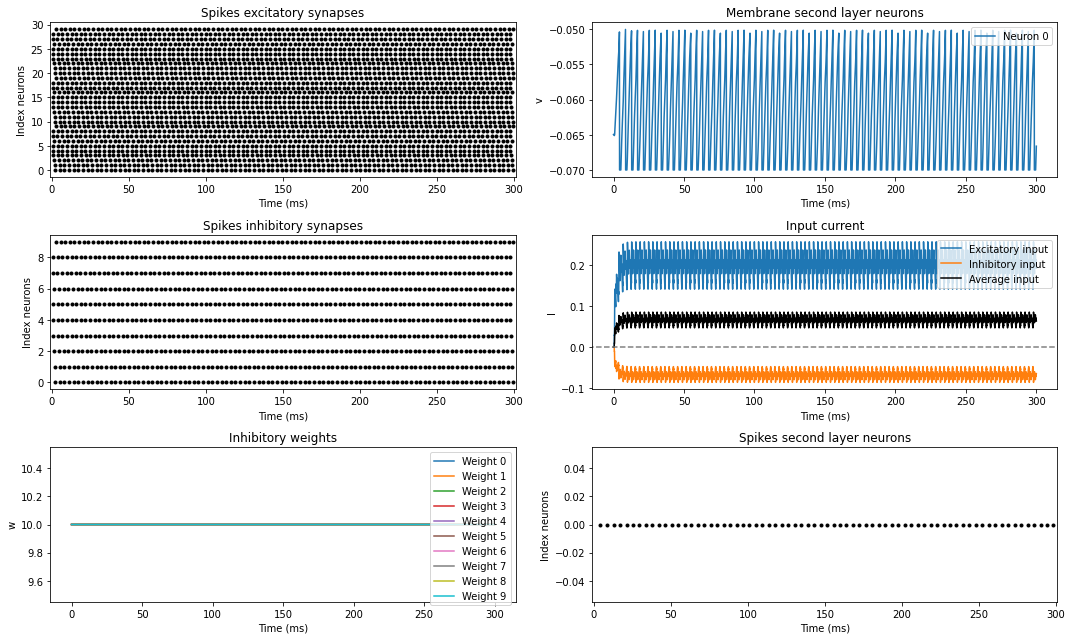

In [5]:
############## MONITORS ##############

# Restart Brian objects
start_scope()


# Restart GeNN backend
if GeNN_backend:
  device.reinit()
  device.activate()


# Parameters
vr = -70*mV
vth = -50*mV
tau = 20*ms
tauI = tau/10 # Much faster than the membrane potential
n_neurons_exc = 30
n_neurons_inh = 10
spk_rate = 300*Hz
spk_period = int(1000/np.array(spk_rate))
refractory = 1*ms


##----- INPUTS UNIFORM -----##
'''
  Uncomment the lines below to use uniform spike trains. 
  The balance excitation/inhibition will be very tight, but the simulation
  will be less realistic
'''
# # Times initial spikes
# ini_inh =  np.random.uniform(low=0, high=3, size=(n_neurons_inh))
# ini_exc =  np.array([ini_inh]*3).flatten()
# # Excitatory
# G_exc = SpikeGeneratorGroup(n_neurons_exc, range(n_neurons_exc), ini_exc*ms, period = spk_period*ms)
# # Inhibitory
# G_inh = SpikeGeneratorGroup(n_neurons_inh, range(n_neurons_inh), ini_inh*ms, period = spk_period*ms)


##----- INPUTS POISSON -----##
'''
  Uncomment the lines below to use poisson spike trains. 
  The balance excitation/inhibition will be not too tight, but the simulation
  will more less realistic
'''
# Excitatory
G_exc = PoissonGroup(n_neurons_exc, spk_rate)
# Inhibitory
G_inh = PoissonGroup(n_neurons_inh, spk_rate)


##----- SECOND LAYER -----##

# Neurons population
#   *They contain an excitatory input (Ie) and inibitory input (Ii)
#   *These input currents are increased with every incoming spike
#   *These input currents decay over time (tend to 0)
eqs='''
dv/dt = (vr - v + (Ie + Ii))/tau : volt (unless refractory)
dIe/dt = -Ie/tauI : volt
dIi/dt = -Ii/tauI : volt
'''
reset='''
v = vr
'''
G_out = NeuronGroup(1, eqs, threshold='v>vth', reset=reset, 
                refractory=refractory, method='euler')


# Initializations neurons
G_out.v = 'vth + rand()*(vr-vth)'
G_out.Ie = '0*mV'
G_out.Ii = '0*mV'


# Synapses 
S_exc = Synapses(G_exc, G_out, 
                 '''
                 w : 1
                 ''',
                 on_pre='''
                 Ie_post += w*mV''',
                 on_post='''
                 ''')
S_inh = Synapses(G_inh, G_out, 
                 '''
                 w : 1

                 ''',
                 on_pre='''
                 Ii_post -= w*mV
                 ''',
                 on_post='''
                 ''')

# Connectivity
S_exc.connect(p=1.0)
S_inh.connect(p=1.0)


# Initializations weights
S_exc.w = 10
S_inh.w = 10


# Monitors
monitor_v = StateMonitor(G_out, 'v', record=True)
monitor_w= StateMonitor(S_inh, 'w', record=True)
monitor_I = StateMonitor(G_out, ['Ie', 'Ii'], record=True)
monitor_spk_in1 = SpikeMonitor(G_exc)
monitor_spk_in2 = SpikeMonitor(G_inh)
monitor_spk_out = SpikeMonitor(G_out)


# Run simulation
simulation_time = 300
run(simulation_time*ms)



# Visualizations
plt.figure(figsize=(15,9))
plt.subplot(321)
plot(monitor_spk_in1.t/ms, monitor_spk_in1.i, '.k')
xlabel('Time (ms)')
ylabel('Index neurons')
plt.title('Spikes excitatory synapses')
plt.xlim(left=-1, right=simulation_time+1)

plt.subplot(322)
plot(monitor_v.t/ms, monitor_v.v[0], label='Neuron '+str(0))
xlabel('Time (ms)')
ylabel('v')
plt.legend(loc='upper right')
plt.title('Membrane second layer neurons')

plt.subplot(323)
plot(monitor_spk_in2.t/ms, monitor_spk_in2.i, '.k')
xlabel('Time (ms)')
ylabel('Index neurons')
plt.title('Spikes inhibitory synapses')
plt.xlim(left=-1, right=simulation_time+1)

plt.subplot(324)
plot(monitor_v.t/ms, monitor_I.Ie[0], label='Excitatory input')
plot(monitor_v.t/ms, monitor_I.Ii[0], label='Inhibitory input')
plot(monitor_v.t/ms, np.mean([monitor_I.Ie[0], monitor_I.Ii[0]], axis=0), label='Average input', color='black')
xlabel('Time (ms)')
ylabel('I')
plt.legend(loc='upper right')
plt.title('Input current')
plt.axhline(y=0, xmin=-1, xmax=simulation_time+1, color='gray', linestyle='--')

plt.subplot(325)
for n in range(len(monitor_w.w)):
  plot(monitor_w.t/ms, monitor_w.w[n], label='Weight '+str(n))
xlabel('Time (ms)')
ylabel('w')
plt.legend(loc='upper right')
plt.title('Inhibitory weights')

plt.subplot(326)
plot(monitor_spk_out.t/ms, monitor_spk_out.i, '.k')
xlabel('Time (ms)')
ylabel('Index neurons')
plt.title('Spikes second layer neurons')
plt.xlim(left=-1, right=simulation_time+1)
plt.tight_layout()
plt.show()

